# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [65]:
df = pd.read_csv('normally_generated_seasoned_data.csv')
df = pd.DataFrame(df['Power'])
df

,Power
0,792
1,733
2,706
3,684
4,784
...,...
26179,1122
26180,1131
26181,953
26182,762


**Scaling**

In [66]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Power'])
df

,Power
0,-0.194168
1,-0.205339
2,-0.210452
3,-0.214617
4,-0.195683
...,...
26179,-0.131686
26180,-0.129982
26181,-0.163685
26182,-0.199849


# Separate train and test data

In [67]:
training_data_len = int(len(df)*0.8)
validation_data_len = int(len(df)*0.1)
print(training_data_len)
print(validation_data_len)

train_data = df[:training_data_len]
validation_data = df[training_data_len:training_data_len+validation_data_len]
test_data = df[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

20947
2618
(20947, 1) (2618, 1) (2619, 1)


In [68]:
print(train_data['Power'].mean())
print(validation_data['Power'].mean())
print(test_data['Power'].mean())

-0.12010881919923394
-0.12347053406578602
-0.12146799560461911


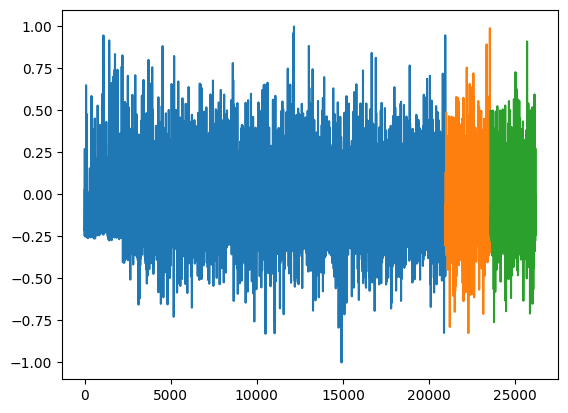

In [69]:
plt.plot(train_data['Power'])
plt.plot(validation_data['Power'])
plt.plot(test_data['Power'])
plt.show()

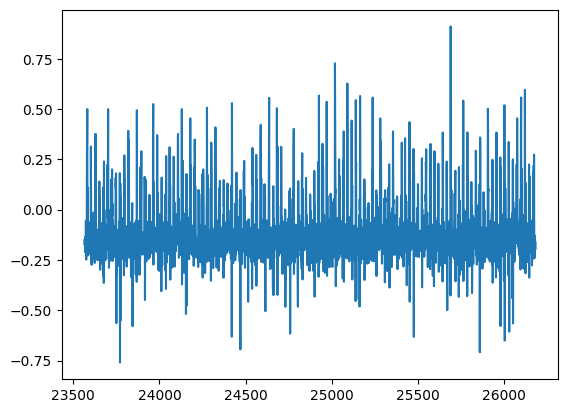

In [70]:
plt.plot(test_data['Power'])
plt.show()

In [71]:
dataset_train = train_data['Power'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(20947, 1)

In [72]:
dataset_validation = validation_data['Power'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
dataset_validation.shape

(2618, 1)

In [73]:
dataset_test = test_data['Power'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(2619, 1)

**Create Sequences**

In [74]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [75]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((20923, 24, 1), (20923, 24, 1))

In [76]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_validation.shape, y_validation.shape

((2594, 24, 1), (2594, 24, 1))

In [77]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((2595, 24, 1), (2595, 24, 1))

**Convert to Tensors**

In [78]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([20923, 24, 1]) torch.Size([20923, 24, 1])
torch.Size([2594, 24, 1]) torch.Size([2594, 24, 1])
torch.Size([2595, 24, 1]) torch.Size([2595, 24, 1])


# Create Model

In [79]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, drop_out=0.0):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=drop_out)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [81]:
input_size = 1
num_layers = 2
hidden_size = 34
output_size = 1
drop_out = 0.48057
learning_rate = 0.00907

model = LSTM(input_size, hidden_size, num_layers, drop_out).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr=0.00314)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00314)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00314)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00314)

print(model)

LSTM(
  (lstm): LSTM(1, 34, num_layers=2, batch_first=True, dropout=0.48057)
  (fc): Linear(in_features=34, out_features=1, bias=True)
)


**Torch Dataloader**

In [82]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [83]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 24, 1]), y shape: torch.Size([32, 24, 1])


# Train the Model

In [84]:
num_epochs = 50
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# predictions = predictions[:, -1, :]
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation).to(device)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


Epoch [10/50] - Training Loss: 0.0184, Validation Loss: 0.0215
Epoch [20/50] - Training Loss: 0.0166, Validation Loss: 0.0228
Epoch [30/50] - Training Loss: 0.0158, Validation Loss: 0.0238
Epoch [40/50] - Training Loss: 0.0153, Validation Loss: 0.0239
Epoch [50/50] - Training Loss: 0.0150, Validation Loss: 0.0238


In [85]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Validation MAPE: {validation_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 154.88, Validation MAPE: 98.99
Epoch 20 - Training MAPE: 168.39, Validation MAPE: 111.00
Epoch 30 - Training MAPE: 170.18, Validation MAPE: 121.24
Epoch 40 - Training MAPE: 167.84, Validation MAPE: 124.22
Epoch 50 - Training MAPE: 167.44, Validation MAPE: 121.97


In [86]:
print(f'Training MAPE: {train_mape_hist[-1]:.2f}, Validation MAPE: {validation_mape_hist[-1]:.2f}')

Training MAPE: 167.44, Validation MAPE: 121.97


In [87]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

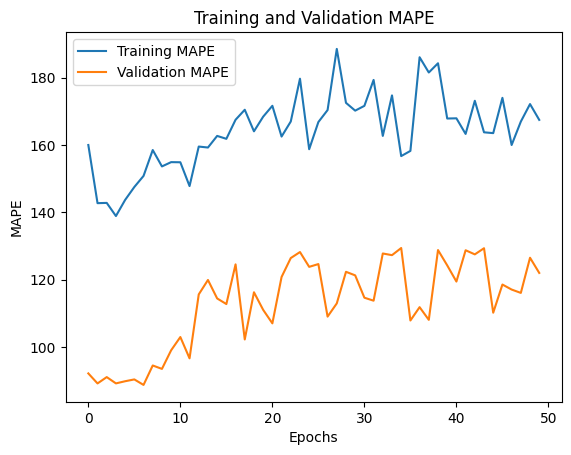

In [88]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.title("Training and Validation MAPE")
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.legend()
plt.show()

# Evaluate on Test Data

In [89]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions = model(batch_X_test)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])


In [90]:
# MAPE on test data
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on test data = 165.42


In [91]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

,Predicted Power,Actual Power
0,924.301147,898.999965
1,910.584047,661.999993
2,905.201957,673.000038
3,937.425791,1480.999991
4,1007.658574,1167.000018
...,...,...
2590,920.581526,1121.999987
2591,949.823478,1131.000017
2592,934.163577,952.999987
2593,903.425844,761.999975


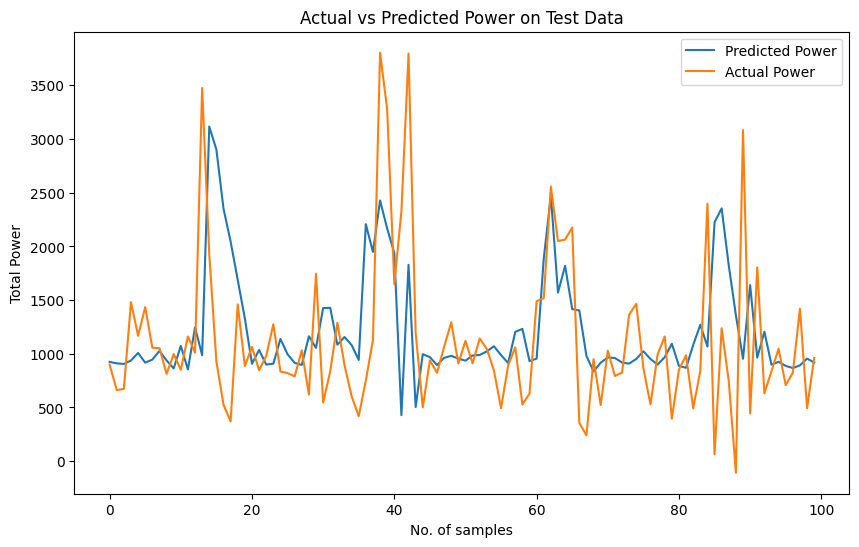

In [92]:
# plot actual vs predicted powers on first test data
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_original[:100], label='Predicted Power')
plt.plot(actuals_test_original[:100], label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Training Data

In [93]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])


In [94]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on train data = 161.14


In [95]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})

,Predicted Power,Actual Power
0,980.715385,1279.000013
1,925.171575,597.999973
2,943.961787,793.999984
3,1148.312391,1228.999983
4,916.400563,811.999965
...,...,...
20918,1694.948277,230.999947
20919,1002.255313,903.999964
20920,936.325479,1036.000034
20921,948.879387,855.999989


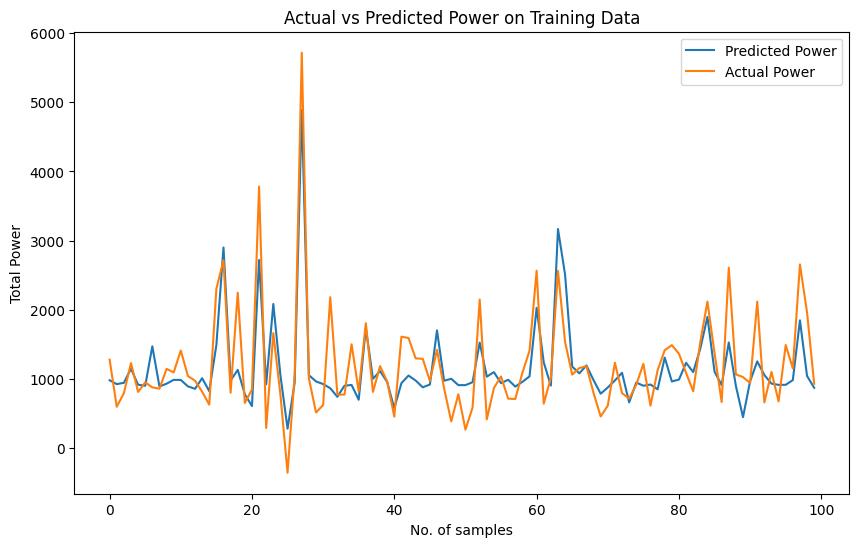

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_train_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_train_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-Evaluate on Validation Data

In [97]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy()[:, :]
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy()[:, :]
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [98]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on validation data = 122.76


In [99]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

,Predicted Power,Actual Power
0,910.171892,838.999976
1,936.771396,577.000009
2,937.558244,580.999961
3,953.270874,893.999966
4,992.076586,1012.000007
...,...,...
2589,2728.647757,399.999947
2590,710.891724,967.000015
2591,1645.120208,1382.999986
2592,1638.831606,945.999972


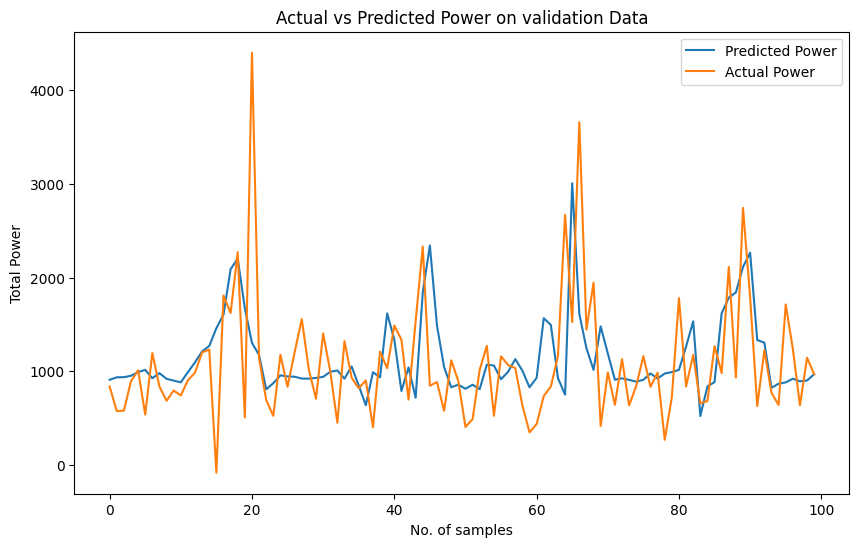

In [100]:
# plot on first 100 validation data
plt.figure(figsize=(10, 6))
plt.plot(predictions_validation_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_validation_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()